In [ ]:
import os

os.chdir("drive/MyDrive/DuyguTanima")

In [ ]:
!ls

data  Duygu_Tanima.ipynb  example_submission.csv  fer2013  icml_face_data.csv  test.csv  train.csv


##Gerekli Paketlerin Yüklenmesi

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

##Veri setinin okunması

In [ ]:
root = "/content/drive/MyDrive/DuyguTanima"
data = pd.read_csv(root + "/fer2013/fer2013.csv")
data.shape

(35887, 3)

##Veriden bir kısım görelim!

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data["Usage"].value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


#EĞİTİM VERİSİ İÇİN ÖN İŞLEME ADIMLARI

In [ ]:
np.unique(data["Usage"].values.ravel())

print("Eğitim setindeki örnek sayısı: %d"%(len(data[data.Usage == "Training"])))

Eğitim setindeki örnek sayısı: 28709


##Eğitim işlemi için veri kümesinde ayrılmış olan Training kısmını alıyoruz.

In [ ]:
train_data = data[data.Usage == "Training"]

In [ ]:
#eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
train_pixels = train_data.pixels.str.split(" ").tolist()
train_pixels = pd.DataFrame(train_pixels).astype(int)
train_images = train_pixels.values.astype(float)
print(train_images)
print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [ ]:
#Görüntüyü 48x48 piksel şeklinde göstermek için bir fonksiyon tanımlayalım
def show(img):
  show_image = img.reshape(48,48)

  plt.axis("off")
  plt.imshow(show_image, cmap="gray")

##Eğitim kümesinden bir örnek görsel


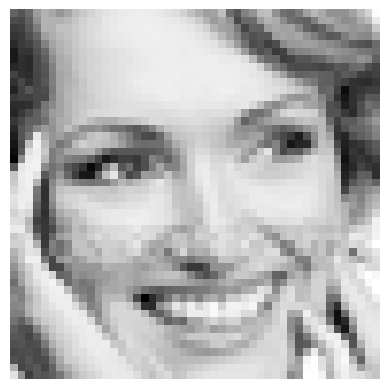

In [ ]:
show(train_images[28687])

##Eğitim kümesinde kaç sınıf bulunuyor bunu görelim.

In [ ]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print("Farklı yüz ifadelerinin sayısı: %d"%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


In [ ]:
def dense_to_one_hot(labels_dense, num_classes):
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels,num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

In [ ]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


##TEST VERİSİ ÖN İŞLEME ADIMLARI

In [ ]:
np.unique(data["Usage"].values.ravel())

print("Test setindeki örnek sayısı: %d"%(len(data[data.Usage == "PublicTest"])))

Test setindeki örnek sayısı: 3589


###Eğitim işlemi için veri kümesinde ayrılmış olan PublicTest kısmını alıyoruz.

In [ ]:
import pandas as pd
import numpy as np

# Extract the pixel data from the 'PublicTest' subset
test_data = data[data.Usage == "PublicTest"]

# Convert the pixel strings into lists of floats
test_pixels = test_data.pixels.str.split(" ").apply(lambda x: [float(pixel) for pixel in x if pixel != ''])

# Convert the list of pixel values into a DataFrame
test_pixels_df = pd.DataFrame(test_pixels.tolist())

# Convert the DataFrame to a numpy array with float64 data type
test_images = test_pixels_df.values.astype(np.float64)

print(test_images.shape)


#test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse edilerek liste olarak değişkene aldık

(3589, 2304)


###Eğitim kümesinden bir örnek görsel

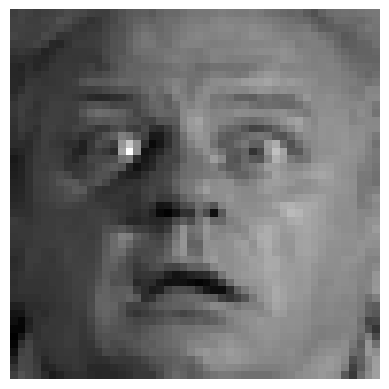

In [ ]:
#bir test örneği gösterelim
show(test_images[1000])

###One Hot ile test kümesindeki verilerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim.

In [ ]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


##TEST KÜMESİNDEN ÖRNEK GÖRÜNTÜLER

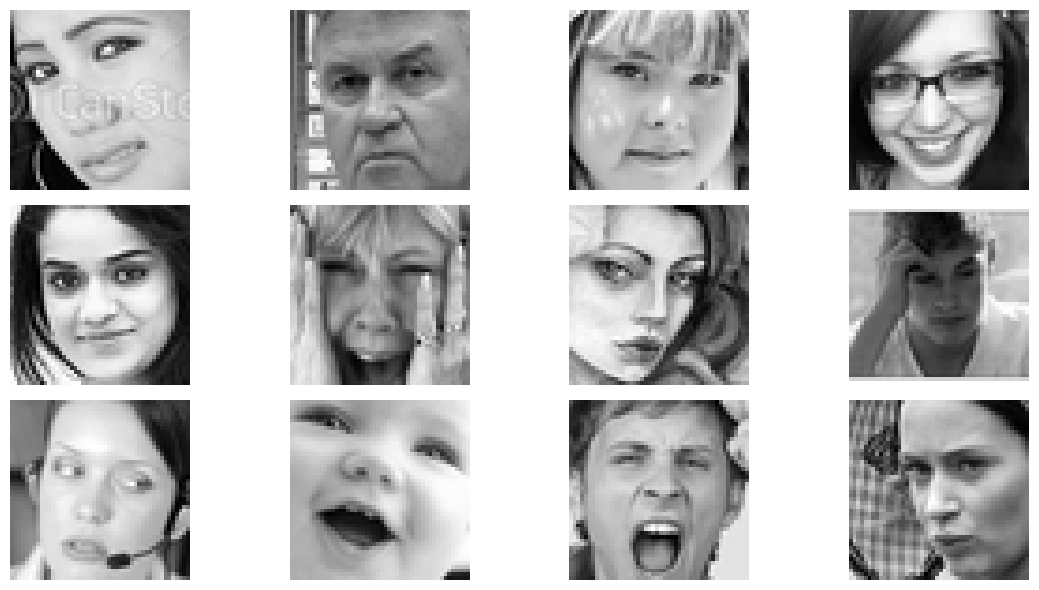

In [ ]:
#test verisetinden örneklerden bir kaçını toplu halde görelim
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3,4,i)
  plt.axis("off")

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap="gray")

plt.tight_layout()
plt.show()

#DERİN EVRİŞİMLİ SİNİR AĞI MODELİ TANIMLANMASI

In [ ]:
model = Sequential()

#1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2. KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### 3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

### 4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

### 5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

###TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### Çıkış katmanı
model.add(Dense(7))
model.add(Activation("softmax")) #Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) #optimizasyon ve başarım hesaplama metriklerinin belirlenmesi

#model özetini görselleştirelim
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 44, 44, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 44, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 32)            │              

 Total params: 339,111 (1.29 MB)

 Trainable params: 338,407 (1.29 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print("Train:", x_train.shape)
print("Test:", x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


##Eğitim ve Test kümelerinin eleman ve duygu sınıf sayısı.

In [ ]:
print("Train:", y_train.shape)
print("Test:", y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


##Eğitim işleminin gerçekleşmesini istediğimiz epoch, batchsize gibi değerlerin  belirlenmesi ve eğitim sonucunda ağırlıkların .h5 dosyası olarak kaydedilmesi işlemleri

In [ ]:
#en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + "data/face_model.keras", verbose=1, save_best_only=True)

epochs = 10
batchSize = 100

#modeli çalıştır
hist = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batchSize, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=2)

#save model to json
model_json = model.to_json()
with open(root + "data/face_model.json", "w") as json_file:
  json_file.write(model_json)

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.62409, saving model to /content/drive/MyDrive/DuyguTanimadata/face_model.keras
288/288 - 626s - 2s/step - accuracy: 0.2500 - loss: 2.0276 - val_accuracy: 0.3675 - val_loss: 1.6241
Epoch 2/10

Epoch 2: val_loss improved from 1.62409 to 1.50646, saving model to /content/drive/MyDrive/DuyguTanimadata/face_model.keras
288/288 - 622s - 2s/step - accuracy: 0.3498 - loss: 1.6581 - val_accuracy: 0.4196 - val_loss: 1.5065
Epoch 3/10

Epoch 3: val_loss improved from 1.50646 to 1.45798, saving model to /content/drive/MyDrive/DuyguTanimadata/face_model.keras
288/288 - 619s - 2s/step - accuracy: 0.3983 - loss: 1.5422 - val_accuracy: 0.4372 - val_loss: 1.4580
Epoch 4/10

Epoch 4: val_loss did not improve from 1.45798
288/288 - 626s - 2s/step - accuracy: 0.4237 - loss: 1.4842 - val_accuracy: 0.4277 - val_loss: 1.4891
Epoch 5/10

Epoch 5: val_loss improved from 1.45798 to 1.33271, saving model to /content/drive/MyDrive/DuyguTanimadata/face_model.ker

##Eğitim sonucu elde edilen Eğitim ve Geçerleme (Validation) sonuçlarının grafiksel olarak ifade edilip ekrana yazdırılması işlemleri

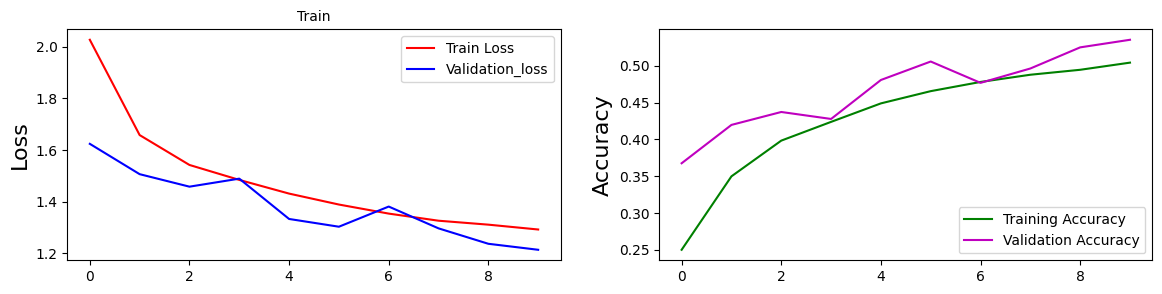

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.title("Train", fontsize=10)
plt.ylabel("Loss", fontsize=16)
plt.plot(hist.history["loss"], color="r", label="Train Loss")
plt.plot(hist.history["val_loss"], color="b", label="Validation_loss")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.ylabel("Accuracy", fontsize=16)
plt.plot(hist.history["accuracy"], color="g", label="Training Accuracy")
plt.plot(hist.history["val_accuracy"], color="m", label="Validation Accuracy")
plt.legend(loc="lower right")

##Kaggle submit edecek gibi **PrivateTest** örnekleri ile test edelim.

In [ ]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=" "))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [ ]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [ ]:
from tensorflow.keras.utils import to_categorical  # Import to_categorical

x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = to_categorical(y_test_private)  # Use to_categorical here

print(x_test_private.shape, y_test_private.shape)

(3589, 48, 48, 1) (3589, 7)


In [ ]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

PrivateTest üzerindeki doğruluk durumu: [1.1967428922653198, 0.53886878490448]


##Veri kümesindeki eğitim kısmı ile modeli eğitip test için ayrılan veri ile test işlemlerini yaptık.

#Farklı görüntülerle test işlemlerini yapıp sonuçları görselleştirelim.

In [ ]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

##Daha önceki eğitimde kaydettiğimiz modelin hesaplandığını öğrenilmmiş ağırlık dosyasını kullanıyoruz.

In [ ]:
#en iyi ağırlıkları yükle
model_best = load_model(root + "data/face_model.keras")

In [82]:
test_image = x_test_private[100]
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data =np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[4.3559866e-03, 4.4385346e-05, 1.3917388e-01, 1.0120557e-03,
        9.0662797e-04, 8.5301870e-01, 1.4883983e-03]], dtype=float32)

#SONUÇLARIN GÖRSELLEŞTİRİLMESİ ADIMLARI

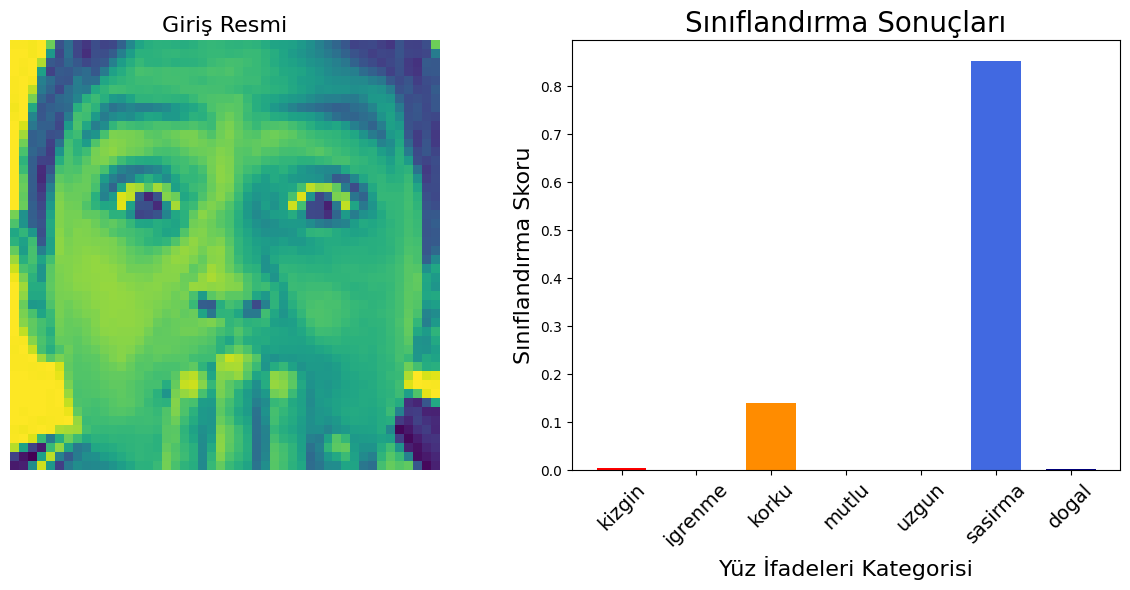

Sınıflandırma sonucu en yüksek oranla: sasirma


In [85]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# First subplot: Display the input image
axes[0].imshow(test_image)
axes[0].set_title("Giriş Resmi", fontsize=16)
axes[0].axis("off")

# Second subplot: Display the classification results as a bar plot
ind = 0.1 + 0.6 * np.arange(len(class_names))
width = 0.4
color_list = ["red", "orangered", "darkorange", "limegreen", "darkgreen", "royalblue", "navy"]

# Plot bars in the second subplot
for i in range(len(class_names)):
    axes[1].bar(ind[i], results[0][i], width, color=color_list[i])

axes[1].set_title("Sınıflandırma Sonuçları", fontsize=20)
axes[1].set_xlabel("Yüz İfadeleri Kategorisi", fontsize=16)
axes[1].set_ylabel("Sınıflandırma Skoru", fontsize=16)
axes[1].set_xticks(ind)
axes[1].set_xticklabels(class_names, rotation=45, fontsize=14)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

# Print the highest scored emotion
print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])
